Title: Mercedes-Benz Greener Manufacturing - Kaggle Competition
Date: 2017-06-29
Author: Dario Arcos-Díaz

# Mercedes-Benz Greener Manufacturing - Kaggle Competition

In this post, I analyze the data from the Mercedes-Benz Kaggle Competition, which aims to better predict the time spent in quality testing for different car configurations. The idea is that if the company would then be able to improve the planning of the tests and reduce the amount of CO2 emmitted from only testing their cars. With this in mind, let's take a look!


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
% matplotlib inline
import seaborn as sns
sns.set_palette('Spectral')
import time
import os

#import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import check_array
from sklearn.linear_model import LassoLarsCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Quickstart
# load train and test data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

##############################################
# homogenize median of duplicates in train set
features = train.columns[2:]
cat_features = []
for c in train.columns:
    if train[c].dtype == 'object':
        cat_features.append(c)
duplicates = train[train.duplicated(subset=features, keep=False)].sort_values(by=cat_features)
medians = pd.read_csv('input/X0X118X127medians.csv')
medians = medians[medians.columns[:6]]
medians = medians.dropna(axis=0, subset=['y_median'])


def get_median(a, b, c):
    criterion1 = (medians['X0'] == a)
    criterion2 = (medians['X118'] == b)
    criterion3 = (medians['X127'] == c)
    return medians[criterion1 & criterion2 & criterion3].y_median.values[0]


def replace_median(df):
    df['y'] = get_median(df['X0'], df['X118'], df['X127'])
    return df


duplicates = duplicates.apply(lambda x: replace_median(x), axis=1)
train.loc[train.ID.isin(duplicates.ID), 'y'] = duplicates['y']
##############################################################

# encode categorical data
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))
# remove the previously identified outlier
#train = train.drop(883, axis=0)
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test

# Data description

1234567890123456789012345678901234567890123456789012345678901234567890123456789

The data comes in two files that can be imported into pandas DataFrames.

In [2]:
# load train and test data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

print('Training data consists of ',
      '{0} examples and {1} features\n'.format(train.shape[0], train.shape[1]),
      'Testing data consists of ',
      '{0} examples and {1} features'.format(test.shape[0], test.shape[1]))

Training data consists of  4209 examples and 378 features
 Testing data consists of  4209 examples and 377 features


In [23]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print('The data types of the features present in the trining set are:')
print(train.dtypes.value_counts())

The data types of the features present in the trining set are:
int64      369
object       8
float64      1
dtype: int64


The feature set consists of:
- ID variable
- y target variable (only in training set)
- 8 categorical features X0-X8 (there is no X7 and no X9)
- 368 binary features X10-X385

We will have to handle categorical and binary features differently.

## Categorical features

First, we should see what kind of categories are documented in the categorical features and whether there are any differences between the train and test data sets.

In [28]:
# Train data
for c in train.columns:
    if train[c].dtype == 'object':
        print(c, 'has unique values:', train[c].nunique(), train[c].unique())
        print('\n')

X0 has unique values: 47 ['k' 'az' 't' 'al' 'o' 'w' 'j' 'h' 's' 'n' 'ay' 'f' 'x' 'y' 'aj' 'ak' 'am'
 'z' 'q' 'at' 'ap' 'v' 'af' 'a' 'e' 'ai' 'd' 'aq' 'c' 'aa' 'ba' 'as' 'i'
 'r' 'b' 'ax' 'bc' 'u' 'ad' 'au' 'm' 'l' 'aw' 'ao' 'ac' 'g' 'ab']


X1 has unique values: 27 ['v' 't' 'w' 'b' 'r' 'l' 's' 'aa' 'c' 'a' 'e' 'h' 'z' 'j' 'o' 'u' 'p' 'n'
 'i' 'y' 'd' 'f' 'm' 'k' 'g' 'q' 'ab']


X2 has unique values: 44 ['at' 'av' 'n' 'e' 'as' 'aq' 'r' 'ai' 'ak' 'm' 'a' 'k' 'ae' 's' 'f' 'd'
 'ag' 'ay' 'ac' 'ap' 'g' 'i' 'aw' 'y' 'b' 'ao' 'al' 'h' 'x' 'au' 't' 'an'
 'z' 'ah' 'p' 'am' 'j' 'q' 'af' 'l' 'aa' 'c' 'o' 'ar']


X3 has unique values: 7 ['a' 'e' 'c' 'f' 'd' 'b' 'g']


X4 has unique values: 4 ['d' 'b' 'c' 'a']


X5 has unique values: 29 ['u' 'y' 'x' 'h' 'g' 'f' 'j' 'i' 'd' 'c' 'af' 'ag' 'ab' 'ac' 'ad' 'ae' 'ah'
 'l' 'k' 'n' 'm' 'p' 'q' 's' 'r' 'v' 'w' 'o' 'aa']


X6 has unique values: 12 ['j' 'l' 'd' 'h' 'i' 'a' 'g' 'c' 'k' 'e' 'f' 'b']


X8 has unique values: 25 ['o' 'x' 'e' 'n' 's' 'a' 'h' 'p' 'm

In [22]:
# Test data
for c in test.columns:
    if test[c].dtype == 'object':
        print(c, 'has unique values:', test[c].nunique())

X0 has unique values: 49
X1 has unique values: 27
X2 has unique values: 45
X3 has unique values: 7
X4 has unique values: 4
X5 has unique values: 32
X6 has unique values: 12
X8 has unique values: 25


In [32]:
for c in [c for c in train.columns if train[c].dtype == 'object']:
    print(c, 'has these unique values in train but not in test:')
    for f in train[c].unique():
        if f not in test[c].unique():
            print(f)

X0 has these unique values in train but not in test:
q
aa
ac
ab
X1 has these unique values in train but not in test:
X2 has these unique values in train but not in test:
l
aa
c
o
ar
X3 has these unique values in train but not in test:
X4 has these unique values in train but not in test:
X5 has these unique values in train but not in test:
u
X6 has these unique values in train but not in test:
X8 has these unique values in train but not in test:


That means that we would be training our models in some cases on values for our features that will not be present in the test data set. We have to options:
- Delete the observations containing these values so that our models are trained only on data values that will be seen in the test data too
- Leave these observations in the train data because out model should also be theoretically appliable to _other different_ test data sets from the one provided in the competition. Maybe a different test set would include these categories

I propose going with the second option, as we want to have a generally valid model, not only for the particular test set received this time

We now encode the values of the categorical values as integers that can be used in statistical models:

In [3]:
# encode categorical data
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


# PCA an outlier identification

Now that all features are encoded and in a form that we can use for machine learning, we can take a look at the data set altogether. One way to do this is through Principal Component Analysis. With this technique we can create a lower-dimension representation of our high-dimensional data. We will reduce the data to two dimensions, which are easier to visualize.

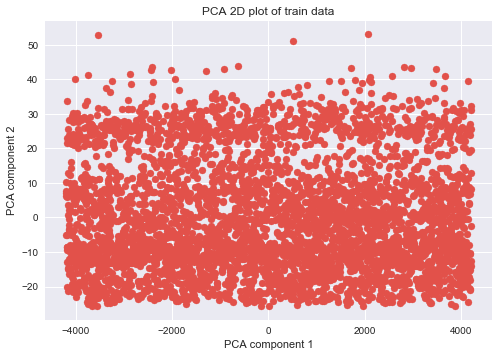

In [37]:
# PCA
n_comp = 2
pca = PCA(n_components=n_comp, random_state=420)
pca2d = pca.fit_transform(train)

# plot PCA, notice an outlier
plt.scatter(pca2d[:, 0], pca2d[:, 1])
plt.title('PCA 2D plot of train data')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

Not too much to see there. Remember that we are reducing _all_ features of the training set to only two dimensions --including the target y and the ID variable, we haven't removed anything yet. Now let's do just that and remove the ID variable, which, although it could give us some information regarding the order in which car configurations are tested, may also be introducing noise.

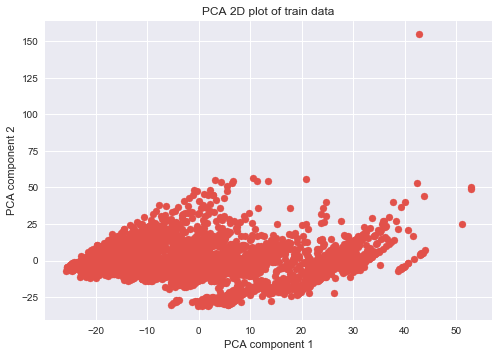

In [41]:
# PCA
n_comp = 2
pca = PCA(n_components=n_comp, random_state=420)
pca2d = pca.fit_transform(train.drop(['ID'], axis=1))

# plot PCA, notice an outlier
plt.scatter(pca2d[:, 0], pca2d[:, 1])
plt.title('PCA 2D plot of train data')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

Looks more informative now. In fact we can see that most data points seem to be in a big cluster on our plot, _except_ for a few ones. One data point in particular seems to be an outlier at the top right of our plot.

Training our later models with outliers in the data might introduce unnecessary noise in our predictions. Therefore, we can try to identify and remove said outlier from the training data.

In [45]:
# identify outlier's index, value and ID
for i, j, k in zip(range(len(pca2d)), pca2d[:, 1], train['ID']):
    if j > 75:
        print('The outlier corresponds to position {0} of the train data, PCA_component_1 equal {1} and ID = {'
              '2}'.format(i, j, k) ) # 883 154.822581442 1770

The outlier corresponds to position 883 of the train data, PCA_component_1 equal 154.82258144191846, and ID = 1770


In [47]:
# the outlier
train[train['ID']==1770]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,51,19,9,5,3,7,11,19,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# remove the previously identified outlier
train = train.drop(883, axis=0)

We can now check again the shape of our train data set to see that we removed one observation:

In [10]:
train.shape

(4208, 378)

# Feature engineering

Since this is not a huge data set (under 5000 examples and relatively few features, we might benefit from generating our own features through feature engineering.

For this we will be using different methods (one of them being again PCA, but this time we want to generate more than 2 features for plotting. We want additional features that we can then add to the training set and use in our model. We create 12 features using 5 different methods as follows and save them in two separate sets _extra_features_train_ and _extra_features_test_ 

In [49]:
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test

In [7]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(X_train)
tsvd_results_test = tsvd.transform(X_test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(X_train)
pca2_results_test = pca.transform(X_test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(X_train)
ica2_results_test = ica.transform(X_test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(X_train)
grp_results_test = grp.transform(X_test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(X_train)
srp_results_test = srp.transform(X_test)

# create empty dataframes to capture extra features
extra_features_train = pd.DataFrame()
extra_features_test = pd.DataFrame()

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    extra_features_train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    extra_features_test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    extra_features_train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    extra_features_test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    extra_features_train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    extra_features_test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    extra_features_train['grp_' + str(i)] = grp_results_train[:, i - 1]
    extra_features_test['grp_' + str(i)] = grp_results_test[:, i - 1]

    extra_features_train['srp_' + str(i)] = srp_results_train[:, i - 1]
    extra_features_test['srp_' + str(i)] = srp_results_test[:, i - 1]

extra_features_train.shape, extra_features_test.shape

((4209, 60), (4209, 60))

# Stacked model

I am going to use an ensemble model strategy. I will fit two different models separately and then average/weigh them together to produce the final predictions.

The first model will be a *Stacked Model* that will itself consist of a pipeline, sequentially, of:

- LassoLarsCV
- GradientBoostingRegressor
- LassoLarsCV

The principle of the pipeline is that a first transformer is applied, and the results of this transformation are passed on to the next transformer and so on. In order to do this, each step in the pipeline (except for the last one) must perform a fit_transform. The LassoLarsCV does not have by itself a fit_transform function, therefore we must create a StackingEstimator wrapper to give it the fit_transform method: inheriting from TransformerMixin, we define fit, transform and get fit_transform for free :)

In [4]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        
        # add class probabilities as a synthetic additional feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prediction as a synthetic additional feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

Now any estimator that we wrap with this class will possess a fit_transform method and can be used in the pipeline. We can now create the pipeline, fit it and then make the first set of predictions _y_pred1_

In [5]:
seed=420
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, 
                                                          max_features=0.55, min_samples_leaf=18, min_samples_split=14, 
                                                          subsample=0.7, random_state=seed)),
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    LassoLarsCV()
)
# stacked model is trained without the extra features
t0 = time.time()
stacked_pipeline.fit(X_train, y_train)
y_pred1 = stacked_pipeline.predict(X_test)
print("Done: {:.1f} s".format(time.time() - t0))

Done: 4.9 s


We want to have a measurement of the accuracy of our model. For this we cross-validate using the KFold method, in which the data set is split in k "folds" and the model is trained on k-1 parts, while the remaining part is used for cross validation.

I performed the cross validation for other configurations of stacked models for comparison. The details can be found [in this notebook](https://github.com/dariodata/mercedes-manufacturing/cross-validation).

In [6]:
# evaluate pipeline
t0 = time.time()
seed = 420
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(stacked_pipeline, X_train, y_train, cv=kfold)
print('Accuracy:', results.mean())
print("Done: {:.1f} s".format(time.time() - t0))

Accuracy: 0.600803113327
Done: 40.7 s


# XGB Model

On to our second model. Here we will use XGBoost to create a different set of predictions that we will then average with our previous Stacked Model. For the XGBoost model we will include the extra features that were generated from the feature engineering in order to fit the model.

In [8]:
X_train = np.hstack((X_train, extra_features_train))
X_test = np.hstack((X_test, extra_features_test))

In [10]:
import xgboost as xgb

In [13]:
# train XGB
print('Training')
t0 = time.time()
num_round = 520
eta = 0.0045
param = {'n_trees': 520, 
         'max_depth':4, 
         'min_child_weight':4,
         'eta':eta, 'learning_rate':eta,
         'silent':1, 'objective':'reg:linear', 
         'subsample':0.93,# 'colsample_bytree':0.5, 
         'n_estimators':num_round, 'num_boost_round':num_round}
dtrain = xgb.DMatrix(data=X_train, label=y_train)
#watchlist  = [(dtest,'test'), (dtrain,'train')]
xgb_model = xgb.train(param, dtrain, num_round)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

Training


Done: 47.3 s


0

In [12]:
# evaluate pipeline
t0 = time.time()
seed = 420
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(xgb.XGBRegressor(**param), X_train, y_train, cv=kfold) # xgb_model in sklearn wrapper
print(results.mean())
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

# 0.573627668125 for xgb_model
# Done: 76.6 s

# 0.573665697336 # xgb_model2
# Done: 1384.7 s

-0.00989167431509
Done: 476.9 s


0

# Cross validation

In [20]:
def evalcoef(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

# train XGB
print('Cross validating')
t0 = time.time()
# param same as for training
# dtrain = xgb.DMatrix(data=X_train, label=y_train)
# watchlist  = [(dtest,'test'), (dtrain,'train')]
num_folds = 10
xgb_modelcv = xgb.cv(param, dtrain, num_round, num_folds, feval=evalcoef)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))
os.system('say "finished running code"')

Cross validating


Done: 543.7 s


0

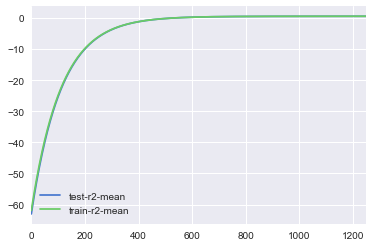

In [21]:
xgb_modelcv[['test-r2-mean', 'train-r2-mean']].plot()
#plt.xlim(400,500)

# Make test predictions

In [14]:
# get predictions from model
dtest = xgb.DMatrix(data=X_test)
y_pred2 = xgb_model.predict(dtest)

In [40]:
# average predictions from stacked model and xgb
y_pred = y_pred2*0.75 + y_pred1*0.25

In [41]:
# create submission csv file
dirname = 'output'
count = len(os.listdir(os.path.join(os.getcwd(), dirname))) + 1
filename = 'sub' + str(count) + '_xgb' + '_maxdepth' + str(param['max_depth']) + '_eta' + str(param['eta']) + \
           '_numround' + str(num_round) + '.csv'
pd.concat([test.ID, pd.Series(y_pred)], axis=1).to_csv(dirname + '/' + filename,
                                                       header=['ID', 'y'], index=False)